In [1]:
# Import libraries
import tqdm
import torch
import random
import torchvision

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Part A

In [4]:
# Load dataset
df = pd.read_csv('/content/BBBP.csv')
df

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...


As you see in following plot, the classes are unbalanced and in traing the model I solved this by using BCLWithLogitsLoss function with weights.

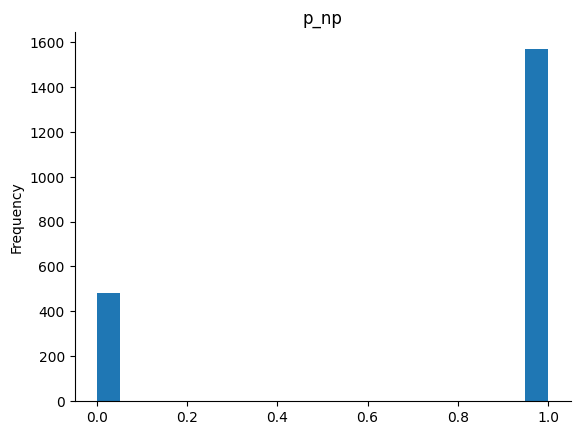

In [9]:
df['p_np'].plot(kind='hist', bins=20, title='p_np')
plt.gca().spines[['top', 'right',]].set_visible(False)

Following function tokenize SMILEs formula and then adds a new column to dataframe which contains the tokenized SMILE.

In [5]:
def tokenize_smiles(smiles):

    tokens = []
    i = 0
    while i < len(smiles):
        # Check if the current and next characters form a two-character element
        current_char = smiles[i]
        next_char = smiles[i + 1] if i + 1 < len(smiles) else None
        if next_char is not None and current_char + next_char in ['Br', 'Cl', '@@']:
            tokens.append(current_char + next_char)
            i += 2
        else:
            tokens.append(current_char)
            i += 1
    return tokens

# apply the function on all rows of the dataframe
df['tokenized'] = df['smiles'].apply(tokenize_smiles)

Following function store the tokenized SMILEs in a set to get the unique tokens.

In [6]:
unique_tokens = set()
for row in df['tokenized'].values :
    for token in row:
        unique_tokens.add(token)

unique_tokens_list = list(unique_tokens)

 In the next cell  I created a token dictionary that maps each token to an index for create one hot encoding.

In [7]:
token_dict = {}
for  idx, token in enumerate(unique_tokens_list):
    token_dict[token] = idx
print(token_dict)

{'B': 0, '\\': 1, '6': 2, '.': 3, ']': 4, ')': 5, 'n': 6, 'S': 7, '+': 8, '0': 9, '1': 10, '4': 11, '2': 12, 'a': 13, 'O': 14, '-': 15, 'I': 16, '#': 17, 's': 18, '3': 19, '%': 20, '8': 21, '7': 22, 'o': 23, '=': 24, 'H': 25, 'c': 26, 'P': 27, 'N': 28, 'Br': 29, '5': 30, 'Cl': 31, 'C': 32, 'F': 33, '@': 34, '@@': 35, '(': 36, '/': 37, '9': 38, '[': 39}


Now I calculated the length of tokenized SMILEs and then plot the lengthes.

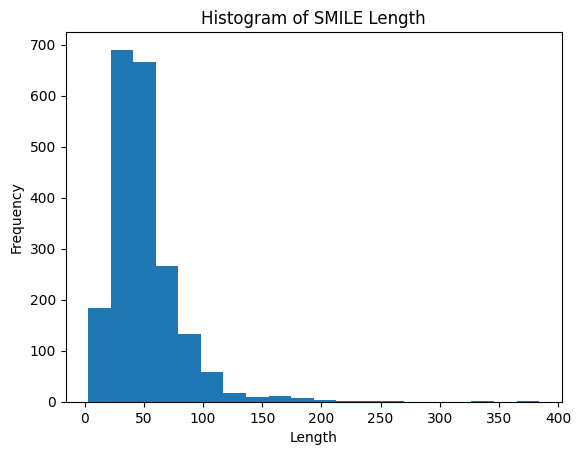

In [12]:
# Apply len function on all row of the tokenized column
lengthes = df['tokenized'].apply(lambda x : len(x))

# plot histogram of lengthes
plt.hist(lengthes , bins=20)
plt.title('Histogram of SMILE Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Get length statistics
max_length = np.max(lengthes)
min_length = np.min(lengthes)
avg_length = np.mean(lengthes)
print(f'Max length in the data set is {max_length} , Min length is {min_length},\n and the average length in tokenized SMILE is about {avg_length.round()}.')

Max length in the data set is 384 , Min length is 3,
 and the average length in tokenized SMILE is 51.0.


In following cell I calculated the frequency of each token and store the number of them in a dictionary and finally plot the frequency of tokens.

In [15]:
# Calculate frequency of each token
token_frequency_dict = {}
for idx, token in enumerate(unique_tokens_list):
    token_frequency_dict[token] = 0

for smile in df['tokenized']:
    for token in smile:
        token_frequency_dict[token] +=1

print(token_frequency_dict)

{'B': 1, '\\': 203, '6': 124, '.': 163, ']': 3479, ')': 10491, 'n': 515, 'S': 510, '+': 121, '0': 8, '1': 4128, '4': 1438, '2': 3370, 'a': 22, 'O': 6208, '-': 123, 'I': 6, '#': 53, 's': 72, '3': 2553, '%': 24, '8': 28, '7': 56, 'o': 49, '=': 8034, 'H': 2392, 'c': 6937, 'P': 11, 'N': 3954, 'Br': 51, '5': 454, 'Cl': 618, 'C': 29784, 'F': 509, '@': 1692, '@@': 1251, '(': 10491, '/': 184, '9': 16, '[': 3479}


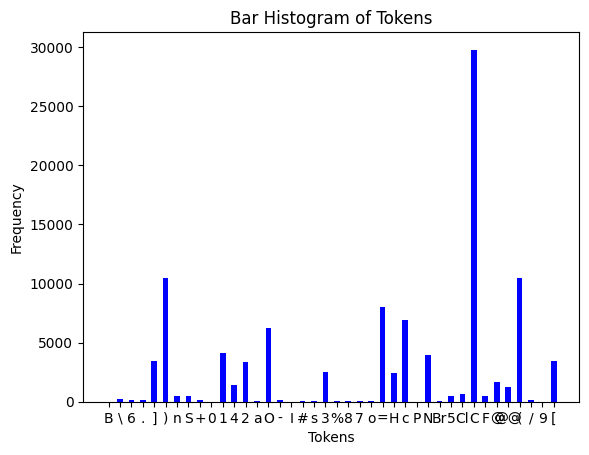

In [18]:
# Extract keys and values from the dictionary
tokens = list(token_frequency_dict.keys())
counts = list(token_frequency_dict.values())

# adjust the width
bar_width = 0.5

# Plotting the bar histogram
plt.bar(tokens, counts,width=bar_width, color='blue')

# Adding labels and title
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title('Bar Histogram of Tokens')
plt.show()

The most frequent token is the C (Carbon atom) and the least one is B (Boron atom).

# Part B

In [42]:
# make multi hot vector for each SMILE formula to feed to MLP
list_of_multi_hots = []
for row in df['tokenized']:
    multi_hot = np.zeros(len(unique_tokens_list)) # 40
    for token in row:
        idx = token_dict[token]
        multi_hot[idx] = 1

    list_of_multi_hots.append(multi_hot)

In [43]:
df['Multi hot for MLP'] = list_of_multi_hots

In [111]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# X shape : 2050x40
X = np.array(df['Multi hot for MLP'].to_list())
y = np.array(df['p_np'].to_list())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create a simple fully connected neural network
class FCModel(nn.Module):
    def __init__(self, input_size):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Define weights for positive and negative classes (pos_weight is around 0.3)
pos_weight = torch.tensor((y_train == 0).sum() / (y_train == 1).sum(), dtype=torch.float32)

# Initialize the model, loss function, and optimizer
fcModel = FCModel(input_size=X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(fcModel.parameters(), lr=0.001)

# Train the model
num_epochs = 10
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):

    fcModel.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        outputs = fcModel(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()

        # Update statistics
        total_loss += loss.item()
        predicted_labels = (fcModel.sigmoid(outputs) >= 0.5).float()
        correct_predictions += torch.sum(predicted_labels.view(-1) == batch_y).item()
        total_samples += len(batch_y)

    # Calculate epoch-level statistics
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    # Print epoch-level information
    print(f"\n Epoch {epoch + 1}/{num_epochs},  Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}%")


# Evaluate the model on the test set
with torch.no_grad():
    fcModel.eval()
    test_outputs = fcModel(X_test_tensor)
    predicted_labels = (fcModel.sigmoid(test_outputs) >= 0.5).float()
    accuracy = torch.sum(predicted_labels.view(-1) == y_test_tensor).item() / len(y_test_tensor)

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

100%|██████████| 52/52 [00:00<00:00, 178.30it/s]



 Epoch 1/10,  Train Loss: 0.3350, Train Accuracy: 76.34%


100%|██████████| 52/52 [00:00<00:00, 335.24it/s]



 Epoch 2/10,  Train Loss: 0.3255, Train Accuracy: 76.34%


100%|██████████| 52/52 [00:00<00:00, 327.21it/s]



 Epoch 3/10,  Train Loss: 0.3206, Train Accuracy: 76.34%


100%|██████████| 52/52 [00:00<00:00, 360.05it/s]



 Epoch 4/10,  Train Loss: 0.3171, Train Accuracy: 76.34%


100%|██████████| 52/52 [00:00<00:00, 703.63it/s]



 Epoch 5/10,  Train Loss: 0.3133, Train Accuracy: 76.34%


100%|██████████| 52/52 [00:00<00:00, 714.57it/s]



 Epoch 6/10,  Train Loss: 0.3064, Train Accuracy: 76.34%


100%|██████████| 52/52 [00:00<00:00, 590.68it/s]



 Epoch 7/10,  Train Loss: 0.3028, Train Accuracy: 76.34%


100%|██████████| 52/52 [00:00<00:00, 679.02it/s]



 Epoch 8/10,  Train Loss: 0.3013, Train Accuracy: 76.34%


100%|██████████| 52/52 [00:00<00:00, 715.67it/s]



 Epoch 9/10,  Train Loss: 0.2974, Train Accuracy: 76.34%


100%|██████████| 52/52 [00:00<00:00, 724.37it/s]


 Epoch 10/10,  Train Loss: 0.2955, Train Accuracy: 76.34%
Accuracy on the test set: 76.83%


#### As you see the tast accuracy of baseline model is 76.83% and the top train accuracy is 76.34%.

# Part C

In [44]:
# find the longest length
lengthes = df['tokenized'].apply(lambda x : len(x))
MAX_LENGTH = np.max(lengthes.to_list())

# create 40D one hot vector for each token (Each SMILE sequence will be a 384x40 tensor)
list_of_data_LSTM = []

for smile in df['tokenized']:
    two_dim_array = np.zeros((MAX_LENGTH, len(unique_tokens_list))) #384X40
    for token_index, token in enumerate(smile):
        idx = token_dict[token]
        two_dim_array[383-token_index][idx] = 1

    list_of_data_LSTM.append(two_dim_array)

In [45]:
np.array(list_of_data_LSTM).shape

(2050, 384, 40)

In [46]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# X_LSTM shape : (2050, 384, 40)
X_LSTM = np.array(list_of_data_LSTM)
y = np.array(df['p_np'].to_list())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_LSTM, y, test_size=0.1, random_state=40)

# Define weights for positive and negative classes (pos_weight is around 0.3)
pos_weight = torch.tensor((y_train == 0).sum() / (y_train == 1).sum(), dtype=torch.float32)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 16)
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        lstm_out, _ = self.lstm(x)

        # Take the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        x = self.fc1(lstm_out)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu1(x)
        x = self.fc3(x)
        # x = self.sigmoid(x)
        return x

# Initialize the LSTM model input_size = 40
input_size = X_train_tensor.shape[2]

# The number of features in the hidden state
hidden_size = 128

# Two stacked LSTM
num_layers = 2

# Binary classification
output_size = 1
lstm_model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001)

# Train the LSTM model
num_epochs = 50
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()

        # Update statistics
        total_loss += loss.item()
        predicted_labels = (lstm_model.sigmoid(outputs) >= 0.5).float()
        correct_predictions += torch.sum(predicted_labels.view(-1) == batch_y).item()
        total_samples += len(batch_y)


    # Calculate epoch-level statistics
    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(train_loader)

    # Print epoch-level information
    print(f"Epoch {epoch + 1}/{num_epochs},  Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}% \n")



# Evaluate the LSTM model on the test set
with torch.no_grad():
    lstm_model.eval()
    test_outputs = lstm_model(X_test_tensor)
    predicted_labels = (lstm_model.sigmoid(test_outputs) >= 0.5).float()
    accuracy = torch.sum(predicted_labels.view(-1) == y_test_tensor).item() / len(y_test_tensor)

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

100%|██████████| 58/58 [00:00<00:00, 83.73it/s]


Epoch 1/50,  Train Loss: 0.3365, Train Accuracy: 24.23% 



100%|██████████| 58/58 [00:00<00:00, 102.29it/s]


Epoch 2/50,  Train Loss: 0.3359, Train Accuracy: 24.23% 



100%|██████████| 58/58 [00:00<00:00, 100.08it/s]


Epoch 3/50,  Train Loss: 0.3353, Train Accuracy: 28.51% 



100%|██████████| 58/58 [00:00<00:00, 99.65it/s]


Epoch 4/50,  Train Loss: 0.3035, Train Accuracy: 72.20% 



100%|██████████| 58/58 [00:00<00:00, 101.91it/s]


Epoch 5/50,  Train Loss: 0.2838, Train Accuracy: 67.37% 



100%|██████████| 58/58 [00:00<00:00, 104.92it/s]


Epoch 6/50,  Train Loss: 0.2643, Train Accuracy: 69.05% 



100%|██████████| 58/58 [00:00<00:00, 103.53it/s]


Epoch 7/50,  Train Loss: 0.2549, Train Accuracy: 67.80% 



100%|██████████| 58/58 [00:00<00:00, 103.00it/s]


Epoch 8/50,  Train Loss: 0.2486, Train Accuracy: 67.32% 



100%|██████████| 58/58 [00:00<00:00, 104.19it/s]


Epoch 9/50,  Train Loss: 0.2406, Train Accuracy: 69.05% 



100%|██████████| 58/58 [00:00<00:00, 102.03it/s]


Epoch 10/50,  Train Loss: 0.2427, Train Accuracy: 69.11% 



100%|██████████| 58/58 [00:00<00:00, 103.98it/s]


Epoch 11/50,  Train Loss: 0.2288, Train Accuracy: 71.27% 



100%|██████████| 58/58 [00:00<00:00, 103.08it/s]


Epoch 12/50,  Train Loss: 0.2430, Train Accuracy: 69.16% 



100%|██████████| 58/58 [00:00<00:00, 103.30it/s]


Epoch 13/50,  Train Loss: 0.2423, Train Accuracy: 68.40% 



100%|██████████| 58/58 [00:00<00:00, 103.61it/s]


Epoch 14/50,  Train Loss: 0.2182, Train Accuracy: 73.98% 



100%|██████████| 58/58 [00:00<00:00, 103.88it/s]


Epoch 15/50,  Train Loss: 0.2171, Train Accuracy: 73.50% 



100%|██████████| 58/58 [00:00<00:00, 101.96it/s]


Epoch 16/50,  Train Loss: 0.2146, Train Accuracy: 73.66% 



100%|██████████| 58/58 [00:00<00:00, 103.34it/s]


Epoch 17/50,  Train Loss: 0.2120, Train Accuracy: 74.69% 



100%|██████████| 58/58 [00:00<00:00, 104.02it/s]


Epoch 18/50,  Train Loss: 0.2108, Train Accuracy: 73.28% 



100%|██████████| 58/58 [00:00<00:00, 102.80it/s]


Epoch 19/50,  Train Loss: 0.2091, Train Accuracy: 75.23% 



100%|██████████| 58/58 [00:00<00:00, 103.27it/s]


Epoch 20/50,  Train Loss: 0.2032, Train Accuracy: 74.96% 



100%|██████████| 58/58 [00:00<00:00, 102.46it/s]


Epoch 21/50,  Train Loss: 0.2046, Train Accuracy: 74.09% 



100%|██████████| 58/58 [00:00<00:00, 100.78it/s]


Epoch 22/50,  Train Loss: 0.1982, Train Accuracy: 75.72% 



100%|██████████| 58/58 [00:00<00:00, 99.02it/s]


Epoch 23/50,  Train Loss: 0.1985, Train Accuracy: 75.45% 



100%|██████████| 58/58 [00:00<00:00, 96.52it/s]


Epoch 24/50,  Train Loss: 0.1935, Train Accuracy: 76.37% 



100%|██████████| 58/58 [00:00<00:00, 98.26it/s]


Epoch 25/50,  Train Loss: 0.1906, Train Accuracy: 76.26% 



100%|██████████| 58/58 [00:00<00:00, 98.87it/s]


Epoch 26/50,  Train Loss: 0.1861, Train Accuracy: 76.80% 



100%|██████████| 58/58 [00:00<00:00, 99.58it/s]


Epoch 27/50,  Train Loss: 0.1850, Train Accuracy: 76.80% 



100%|██████████| 58/58 [00:00<00:00, 101.75it/s]


Epoch 28/50,  Train Loss: 0.1832, Train Accuracy: 77.67% 



100%|██████████| 58/58 [00:00<00:00, 101.22it/s]


Epoch 29/50,  Train Loss: 0.1841, Train Accuracy: 77.78% 



100%|██████████| 58/58 [00:00<00:00, 101.02it/s]


Epoch 30/50,  Train Loss: 0.1840, Train Accuracy: 77.78% 



100%|██████████| 58/58 [00:00<00:00, 102.81it/s]


Epoch 31/50,  Train Loss: 0.1773, Train Accuracy: 78.16% 



100%|██████████| 58/58 [00:00<00:00, 102.65it/s]


Epoch 32/50,  Train Loss: 0.1799, Train Accuracy: 78.16% 



100%|██████████| 58/58 [00:00<00:00, 101.87it/s]


Epoch 33/50,  Train Loss: 0.1810, Train Accuracy: 77.51% 



100%|██████████| 58/58 [00:00<00:00, 102.39it/s]


Epoch 34/50,  Train Loss: 0.1757, Train Accuracy: 78.43% 



100%|██████████| 58/58 [00:00<00:00, 101.21it/s]


Epoch 35/50,  Train Loss: 0.1756, Train Accuracy: 78.37% 



100%|██████████| 58/58 [00:00<00:00, 103.23it/s]


Epoch 36/50,  Train Loss: 0.1758, Train Accuracy: 78.05% 



100%|██████████| 58/58 [00:00<00:00, 102.76it/s]


Epoch 37/50,  Train Loss: 0.1725, Train Accuracy: 78.27% 



100%|██████████| 58/58 [00:00<00:00, 102.14it/s]


Epoch 38/50,  Train Loss: 0.1702, Train Accuracy: 78.75% 



100%|██████████| 58/58 [00:00<00:00, 101.09it/s]


Epoch 39/50,  Train Loss: 0.1708, Train Accuracy: 78.54% 



100%|██████████| 58/58 [00:00<00:00, 101.54it/s]


Epoch 40/50,  Train Loss: 0.1674, Train Accuracy: 78.97% 



100%|██████████| 58/58 [00:00<00:00, 101.53it/s]


Epoch 41/50,  Train Loss: 0.1677, Train Accuracy: 78.59% 



100%|██████████| 58/58 [00:00<00:00, 100.90it/s]


Epoch 42/50,  Train Loss: 0.1636, Train Accuracy: 78.86% 



100%|██████████| 58/58 [00:00<00:00, 100.45it/s]


Epoch 43/50,  Train Loss: 0.1622, Train Accuracy: 78.27% 



100%|██████████| 58/58 [00:00<00:00, 101.15it/s]


Epoch 44/50,  Train Loss: 0.1634, Train Accuracy: 78.75% 



100%|██████████| 58/58 [00:00<00:00, 96.32it/s]


Epoch 45/50,  Train Loss: 0.1602, Train Accuracy: 79.02% 



100%|██████████| 58/58 [00:00<00:00, 96.44it/s]


Epoch 46/50,  Train Loss: 0.1591, Train Accuracy: 78.75% 



100%|██████████| 58/58 [00:00<00:00, 98.25it/s]


Epoch 47/50,  Train Loss: 0.1601, Train Accuracy: 78.75% 



100%|██████████| 58/58 [00:00<00:00, 98.21it/s]


Epoch 48/50,  Train Loss: 0.1633, Train Accuracy: 78.86% 



100%|██████████| 58/58 [00:00<00:00, 98.88it/s]


Epoch 49/50,  Train Loss: 0.1582, Train Accuracy: 78.97% 



100%|██████████| 58/58 [00:00<00:00, 101.67it/s]

Epoch 50/50,  Train Loss: 0.1576, Train Accuracy: 79.08% 

Accuracy on the test set: 74.15%


#### As you see I got accuracy 74.15% in LSTM model on test set and top train accuracy 79%.

# Part D

In [47]:
# Define the BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMClassifier, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Multiply by 2 for bidirectional
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 16)
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        bilstm_out, _ = self.bilstm(x)
        # Concatenate the outputs from the last time step in both directions
        bilstm_out = torch.cat((bilstm_out[:, -1, :hidden_size], bilstm_out[:, 0, hidden_size:]), dim=1)
        x = self.fc1(bilstm_out)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu1(x)
        x = self.fc3(x)
        # x = self.sigmoid(x)
        return x


# Initialize the LSTM model input_size = 40
input_size = X_train_tensor.shape[2]

# Reduced hidden size for bidirectional
hidden_size = 64
num_layers = 2
output_size = 1
bilstm_model = BiLSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)

# Train the BiLSTM model
num_epochs = 50
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    bilstm_model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        outputs = bilstm_model(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()

        # Update statistics
        total_loss += loss.item()
        predicted_labels = (bilstm_model.sigmoid(outputs) >= 0.5).float()
        correct_predictions += torch.sum(predicted_labels.view(-1) == batch_y).item()
        total_samples += len(batch_y)


    # Calculate epoch-level statistics
    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(train_loader)

    # Print epoch-level information
    print(f"Epoch {epoch + 1}/{num_epochs},  Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}% \n")



# Evaluate the BiLSTM model on the test set
with torch.no_grad():
    bilstm_model.eval()
    test_outputs = bilstm_model(X_test_tensor)
    predicted_labels = (bilstm_model.sigmoid(test_outputs) >= 0.5).float()
    accuracy = torch.sum(predicted_labels.view(-1) == y_test_tensor).item() / len(y_test_tensor)

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


100%|██████████| 58/58 [00:00<00:00, 108.95it/s]


Epoch 1/50,  Train Loss: 0.3334, Train Accuracy: 36.53% 



100%|██████████| 58/58 [00:00<00:00, 140.16it/s]


Epoch 2/50,  Train Loss: 0.3432, Train Accuracy: 51.06% 



100%|██████████| 58/58 [00:00<00:00, 141.28it/s]


Epoch 3/50,  Train Loss: 0.3349, Train Accuracy: 56.42% 



100%|██████████| 58/58 [00:00<00:00, 143.55it/s]


Epoch 4/50,  Train Loss: 0.2976, Train Accuracy: 65.26% 



100%|██████████| 58/58 [00:00<00:00, 142.02it/s]


Epoch 5/50,  Train Loss: 0.2508, Train Accuracy: 71.27% 



100%|██████████| 58/58 [00:00<00:00, 142.91it/s]


Epoch 6/50,  Train Loss: 0.2078, Train Accuracy: 74.20% 



100%|██████████| 58/58 [00:00<00:00, 142.96it/s]


Epoch 7/50,  Train Loss: 0.1823, Train Accuracy: 77.29% 



100%|██████████| 58/58 [00:00<00:00, 141.58it/s]


Epoch 8/50,  Train Loss: 0.1650, Train Accuracy: 79.35% 



100%|██████████| 58/58 [00:00<00:00, 141.72it/s]


Epoch 9/50,  Train Loss: 0.1599, Train Accuracy: 80.43% 



100%|██████████| 58/58 [00:00<00:00, 140.31it/s]


Epoch 10/50,  Train Loss: 0.1732, Train Accuracy: 81.79% 



100%|██████████| 58/58 [00:00<00:00, 143.36it/s]


Epoch 11/50,  Train Loss: 0.1748, Train Accuracy: 79.46% 



100%|██████████| 58/58 [00:00<00:00, 141.54it/s]


Epoch 12/50,  Train Loss: 0.1564, Train Accuracy: 82.76% 



100%|██████████| 58/58 [00:00<00:00, 140.78it/s]


Epoch 13/50,  Train Loss: 0.1362, Train Accuracy: 84.44% 



100%|██████████| 58/58 [00:00<00:00, 141.04it/s]


Epoch 14/50,  Train Loss: 0.1470, Train Accuracy: 82.28% 



100%|██████████| 58/58 [00:00<00:00, 141.62it/s]


Epoch 15/50,  Train Loss: 0.1397, Train Accuracy: 83.90% 



100%|██████████| 58/58 [00:00<00:00, 142.28it/s]


Epoch 16/50,  Train Loss: 0.1267, Train Accuracy: 85.96% 



100%|██████████| 58/58 [00:00<00:00, 140.38it/s]


Epoch 17/50,  Train Loss: 0.1296, Train Accuracy: 86.07% 



100%|██████████| 58/58 [00:00<00:00, 140.84it/s]


Epoch 18/50,  Train Loss: 0.1266, Train Accuracy: 85.80% 



100%|██████████| 58/58 [00:00<00:00, 141.37it/s]


Epoch 19/50,  Train Loss: 0.1249, Train Accuracy: 86.72% 



100%|██████████| 58/58 [00:00<00:00, 140.56it/s]


Epoch 20/50,  Train Loss: 0.1387, Train Accuracy: 84.99% 



100%|██████████| 58/58 [00:00<00:00, 140.92it/s]


Epoch 21/50,  Train Loss: 0.1265, Train Accuracy: 85.96% 



100%|██████████| 58/58 [00:00<00:00, 139.77it/s]


Epoch 22/50,  Train Loss: 0.1205, Train Accuracy: 86.99% 



100%|██████████| 58/58 [00:00<00:00, 141.59it/s]


Epoch 23/50,  Train Loss: 0.1179, Train Accuracy: 86.61% 



100%|██████████| 58/58 [00:00<00:00, 133.08it/s]


Epoch 24/50,  Train Loss: 0.1184, Train Accuracy: 87.15% 



100%|██████████| 58/58 [00:00<00:00, 78.50it/s]


Epoch 25/50,  Train Loss: 0.1186, Train Accuracy: 86.99% 



100%|██████████| 58/58 [00:00<00:00, 130.02it/s]


Epoch 26/50,  Train Loss: 0.1088, Train Accuracy: 88.02% 



100%|██████████| 58/58 [00:00<00:00, 128.07it/s]


Epoch 27/50,  Train Loss: 0.1111, Train Accuracy: 87.97% 



100%|██████████| 58/58 [00:00<00:00, 126.04it/s]


Epoch 28/50,  Train Loss: 0.1074, Train Accuracy: 87.97% 



100%|██████████| 58/58 [00:00<00:00, 128.55it/s]


Epoch 29/50,  Train Loss: 0.1129, Train Accuracy: 87.10% 



100%|██████████| 58/58 [00:00<00:00, 124.61it/s]


Epoch 30/50,  Train Loss: 0.1111, Train Accuracy: 88.02% 



100%|██████████| 58/58 [00:00<00:00, 133.15it/s]


Epoch 31/50,  Train Loss: 0.1209, Train Accuracy: 88.29% 



100%|██████████| 58/58 [00:00<00:00, 141.56it/s]


Epoch 32/50,  Train Loss: 0.1074, Train Accuracy: 87.53% 



100%|██████████| 58/58 [00:00<00:00, 138.85it/s]


Epoch 33/50,  Train Loss: 0.0994, Train Accuracy: 89.59% 



100%|██████████| 58/58 [00:00<00:00, 140.64it/s]


Epoch 34/50,  Train Loss: 0.1005, Train Accuracy: 87.86% 



100%|██████████| 58/58 [00:00<00:00, 137.89it/s]


Epoch 35/50,  Train Loss: 0.1001, Train Accuracy: 88.67% 



100%|██████████| 58/58 [00:00<00:00, 139.26it/s]


Epoch 36/50,  Train Loss: 0.1002, Train Accuracy: 89.11% 



100%|██████████| 58/58 [00:00<00:00, 138.42it/s]


Epoch 37/50,  Train Loss: 0.0976, Train Accuracy: 88.73% 



100%|██████████| 58/58 [00:00<00:00, 135.80it/s]


Epoch 38/50,  Train Loss: 0.1037, Train Accuracy: 89.54% 



100%|██████████| 58/58 [00:00<00:00, 140.86it/s]


Epoch 39/50,  Train Loss: 0.0944, Train Accuracy: 89.92% 



100%|██████████| 58/58 [00:00<00:00, 138.69it/s]


Epoch 40/50,  Train Loss: 0.0957, Train Accuracy: 89.49% 



100%|██████████| 58/58 [00:00<00:00, 139.93it/s]


Epoch 41/50,  Train Loss: 0.0964, Train Accuracy: 89.05% 



100%|██████████| 58/58 [00:00<00:00, 139.51it/s]


Epoch 42/50,  Train Loss: 0.0894, Train Accuracy: 89.81% 



100%|██████████| 58/58 [00:00<00:00, 139.54it/s]


Epoch 43/50,  Train Loss: 0.0996, Train Accuracy: 89.76% 



100%|██████████| 58/58 [00:00<00:00, 140.25it/s]


Epoch 44/50,  Train Loss: 0.0895, Train Accuracy: 90.08% 



100%|██████████| 58/58 [00:00<00:00, 136.98it/s]


Epoch 45/50,  Train Loss: 0.0890, Train Accuracy: 90.35% 



100%|██████████| 58/58 [00:00<00:00, 139.74it/s]


Epoch 46/50,  Train Loss: 0.0982, Train Accuracy: 89.65% 



100%|██████████| 58/58 [00:00<00:00, 139.58it/s]


Epoch 47/50,  Train Loss: 0.0867, Train Accuracy: 91.33% 



100%|██████████| 58/58 [00:00<00:00, 140.13it/s]


Epoch 48/50,  Train Loss: 0.0944, Train Accuracy: 90.19% 



100%|██████████| 58/58 [00:00<00:00, 134.86it/s]


Epoch 49/50,  Train Loss: 0.0901, Train Accuracy: 90.08% 



100%|██████████| 58/58 [00:00<00:00, 138.58it/s]

Epoch 50/50,  Train Loss: 0.0847, Train Accuracy: 90.68% 

Accuracy on the test set: 84.88%


#### I used same architecture for the BiLSTM model and as you see the BiLSTM has better performance. I got accuracy 91.33% train and 84.88% test accuracy. That is more better than LSTM model with accuracy 79% and the FC model (the baseline) with 76% .

# Part E

### LSTM Cross Validation

In [48]:
# Initialize the LSTM model input_size = 40
input_size = X_train_tensor.shape[2]

# The number of features in the hidden state
hidden_size = 128

# Two stacked LSTM
num_layers = 2

# Binary classification
output_size = 1
lstm_model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)


# k-fold cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# create array to store accs
all_accuracies = []

X_tensor = torch.tensor(X_LSTM, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and testing sets for this fold
    X_train_fold, X_test_fold = X_tensor[train_index], X_tensor[test_index]
    y_train_fold, y_test_fold = y_tensor[train_index], y_tensor[test_index]

    # Create DataLoader for training set
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Train the LSTM model
    num_epochs = 50
    for epoch in range(num_epochs):
        lstm_model.train()
        total_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = lstm_model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

    # Evaluate the LSTM model on the test set for this fold
    with torch.no_grad():
        lstm_model.eval()
        X_test_fold, y_test_fold = X_test_fold.to(device), y_test_fold.to(device)
        test_outputs = bilstm_model(X_test_fold)
        predicted_labels = (lstm_model.sigmoid(test_outputs) >= 0.5).float()
        accuracy_fold = accuracy_score(y_test_fold.cpu().numpy(), predicted_labels.cpu().numpy())
        all_accuracies.append(accuracy_fold)

        print(f"Test Accuracy on Fold {fold + 1}: {accuracy_fold * 100:.2f}%")

# Print overall performance metrics
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy: {average_accuracy * 100:.2f}%")

Fold 1/5
Epoch 1/50, Loss: 0.3328
Epoch 2/50, Loss: 0.3329
Epoch 3/50, Loss: 0.3321
Epoch 4/50, Loss: 0.3339
Epoch 5/50, Loss: 0.3339
Epoch 6/50, Loss: 0.3338
Epoch 7/50, Loss: 0.3328
Epoch 8/50, Loss: 0.3348
Epoch 9/50, Loss: 0.3331
Epoch 10/50, Loss: 0.3312
Epoch 11/50, Loss: 0.3323
Epoch 12/50, Loss: 0.3330
Epoch 13/50, Loss: 0.3321
Epoch 14/50, Loss: 0.3347
Epoch 15/50, Loss: 0.3347
Epoch 16/50, Loss: 0.3321
Epoch 17/50, Loss: 0.3329
Epoch 18/50, Loss: 0.3330
Epoch 19/50, Loss: 0.3356
Epoch 20/50, Loss: 0.3338
Epoch 21/50, Loss: 0.3338
Epoch 22/50, Loss: 0.3330
Epoch 23/50, Loss: 0.3321
Epoch 24/50, Loss: 0.3329
Epoch 25/50, Loss: 0.3329
Epoch 26/50, Loss: 0.3321
Epoch 27/50, Loss: 0.3329
Epoch 28/50, Loss: 0.3320
Epoch 29/50, Loss: 0.3329
Epoch 30/50, Loss: 0.3338
Epoch 31/50, Loss: 0.3329
Epoch 32/50, Loss: 0.3329
Epoch 33/50, Loss: 0.3320
Epoch 34/50, Loss: 0.3338
Epoch 35/50, Loss: 0.3320
Epoch 36/50, Loss: 0.3321
Epoch 37/50, Loss: 0.3347
Epoch 38/50, Loss: 0.3329
Epoch 39/50,

In [50]:
np.std([88.54,91.46,93.17,88.29,91.71])

1.9052831810520938

#### As you see with 5-fold cross validation the LSTM model average accuracy is 90.63% (-+ 1.90%) and the top accuracy is 93.17% .

### BiLSTM Cross Validation

In [49]:
# Initialize the BiLSTM model input_size = 40
input_size = X_train_tensor.shape[2]

# Reduced hidden size for bidirectional
hidden_size = 64
num_layers = 2
output_size = 1

bilstm_model = BiLSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)

# k-fold cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=40)

# create arrays to store accs
all_accuracies = []

X_tensor = torch.tensor(X_LSTM, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and testing sets for this fold
    X_train_fold, X_test_fold = X_tensor[train_index], X_tensor[test_index]
    y_train_fold, y_test_fold = y_tensor[train_index], y_tensor[test_index]

    # Create DataLoader for training set
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Train the BiLSTM model
    num_epochs = 50
    for epoch in range(num_epochs):
        bilstm_model.train()
        total_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = bilstm_model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

    # Evaluate the BiLSTM model on the test set for this fold
    with torch.no_grad():
        bilstm_model.eval()
        X_test_fold, y_test_fold = X_test_fold.to(device), y_test_fold.to(device)
        test_outputs = bilstm_model(X_test_fold)
        predicted_labels = (bilstm_model.sigmoid(test_outputs) >= 0.5).float()
        accuracy_fold = accuracy_score(y_test_fold.cpu().numpy(), predicted_labels.cpu().numpy())
        all_accuracies.append(accuracy_fold)

        print(f"Test Accuracy on Fold {fold + 1}: {accuracy_fold * 100:.2f}%")

# Print overall performance metrics
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy: {average_accuracy * 100:.2f}%")

Fold 1/5
Epoch 1/50, Loss: 0.3327
Epoch 2/50, Loss: 0.2900
Epoch 3/50, Loss: 0.2041
Epoch 4/50, Loss: 0.1955
Epoch 5/50, Loss: 0.1709
Epoch 6/50, Loss: 0.1711
Epoch 7/50, Loss: 0.1957
Epoch 8/50, Loss: 0.1554
Epoch 9/50, Loss: 0.1573
Epoch 10/50, Loss: 0.1419
Epoch 11/50, Loss: 0.1609
Epoch 12/50, Loss: 0.1384
Epoch 13/50, Loss: 0.1343
Epoch 14/50, Loss: 0.1333
Epoch 15/50, Loss: 0.1287
Epoch 16/50, Loss: 0.1319
Epoch 17/50, Loss: 0.1277
Epoch 18/50, Loss: 0.1547
Epoch 19/50, Loss: 0.1350
Epoch 20/50, Loss: 0.1208
Epoch 21/50, Loss: 0.1272
Epoch 22/50, Loss: 0.1227
Epoch 23/50, Loss: 0.1314
Epoch 24/50, Loss: 0.1239
Epoch 25/50, Loss: 0.1734
Epoch 26/50, Loss: 0.1569
Epoch 27/50, Loss: 0.1342
Epoch 28/50, Loss: 0.1198
Epoch 29/50, Loss: 0.1201
Epoch 30/50, Loss: 0.1273
Epoch 31/50, Loss: 0.1134
Epoch 32/50, Loss: 0.1118
Epoch 33/50, Loss: 0.1263
Epoch 34/50, Loss: 0.1168
Epoch 35/50, Loss: 0.1275
Epoch 36/50, Loss: 0.1289
Epoch 37/50, Loss: 0.1314
Epoch 38/50, Loss: 0.1241
Epoch 39/50,

In [51]:
np.std([87.32,90.49,89.51,96.83,95.37])

3.6061702677494325

#### As you see with 5-fold cross validation the BiLSTM model average accuracy is 91.90% (-+ 3.60%) and the top accuracy is 96.83% .

# Conclusion

#### The baseline model(FC model) accuracy is 76.83% and the top train accuracy is 76.34%.

#### The LSTM model average accuracy is 90.63% (-+ 1.90%) and the top accuracy is 93.17% .

#### The BiLSTM model average accuracy is 91.90% (-+ 3.60 %) and the top accuracy is 96.83% .

#### BiLSTM & LSTM

A BiLSTM processes the input sequence in both forward and backward directions. This allows the model to capture contextual information from both the beginning and the end of the sequence.
For SMILES formulas, where the order of the tokens can be crucial in determining the molecular structure, having information from both directions can be beneficial.

In a LSTM, information from the future is not available when processing a token, potentially leading to information loss.
In contrast, a BiLSTM solve this issue by processing tokens in both directions, ensuring that each token has access to information from both past and future tokens.

In a word the bidirectional nature of the BiLSTM enables it to learn richer feature representations.